In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("/Users/lls/Documents/mlhalos_code/")
import numpy as np

from mlhalos import plot
from mlhalos import machinelearning as ml
from mlhalos import parameters
from mlhalos import distinct_colours
from utils import plot as plot_utils

In [2]:
path = "/Users/lls/Documents/CODE/stored_files/shear/classification/"
#path = "/home/lls/stored_files/shear_quantities/"

In [134]:
den_mean

38.048199952828455

In [133]:
den_mean = ic.final_snapshot.properties["omegaM0"] * pynbody.analysis.cosmology.rho_crit(ic.final_snapshot, z=0)

In [3]:
def get_testing_index():
    training_index = np.load("/Users/lls/Documents/CODE/stored_files/all_out/50k_features_index.npy")
    testing_index = ~np.in1d(np.arange(256 ** 3), training_index)
    return testing_index


def get_training_features(features):
    training_index = np.load("/Users/lls/Documents/CODE/stored_files/all_out/50k_features_index.npy")
    training_features = features[training_index]
    return training_features


def get_testing_features(features):
    testing_index = get_testing_index()
    testing_features = features[testing_index]
    return testing_features


def get_ids_and_halos_test_set():
    # halos are ordered such that each halo mass corresponds to particles in order of particle ID (0,1,2,...)
    # Need to reorder the array such that it has first all IN particles, the all OUT particles

    ic = parameters.InitialConditionsParameters(path="/Users/lls/Documents/CODE/")
    ids = np.concatenate((ic.ids_IN, ic.ids_OUT))
    halos = np.load("/Users/lls/Documents/CODE/stored_files/halo_mass_particles.npy")

    testing_index = get_testing_index()
    ids_tested = ids[testing_index]
    halos_testing_particles = halos[ids_tested]

    return ids_tested, halos_testing_particles

In [4]:
# FALSE NEGATIVES FUNCTIONS

def get_false_negatives(ids, y_predicted, y_true, threshold=None):
    if threshold is None:
        threshold = 0.5

    labels = y_predicted[:, 1] >= threshold
    y_bool = (y_true == 1)

    FNs = ids[~labels & y_bool]
    return FNs


def get_false_negatives_index(y_predicted, y_true, threshold=None):
    if threshold is None:
        threshold = 0.5

    labels = y_predicted[:, 1] >= threshold
    y_bool = (y_true == 1)

    ind = (~labels & y_bool)
    return ind


def false_negatives_ids_index_per_threshold(y_predicted, y_true, threshold_list):
    FNs = np.array([get_false_negatives_index(y_predicted, y_true, threshold=threshold_list[i])
                    for i in range(len(threshold_list))])
    return FNs

In [45]:
# FALSE POSITIVES FUNCTIONS

def get_false_positives(ids, y_predicted, y_true, threshold=None):
    if threshold is None:
        threshold = 0.5

    labels = y_predicted[:, 1] >= threshold
    y_bool = (y_true == 1)

    FPs = ids[labels & ~y_bool]
    return FPs


def get_false_positives_index(y_predicted, y_true, threshold=None):
    if threshold is None:
        threshold = 0.5

    labels = y_predicted[:, 1] >= threshold
    y_bool = (y_true == 1)

    ind = (labels & ~y_bool)
    return ind

def get_true_negatives_index(y_predicted, y_true, threshold=None):
    if threshold is None:
        threshold = 0.5

    labels = y_predicted[:, 1] >= threshold
    y_bool = (y_true == 1)

    ind = (~labels & ~y_bool)
    return ind

def true_negatives_ids_index_per_threshold(y_predicted, y_true, threshold_list):
    TNs = np.array([get_true_negatives_index(y_predicted, y_true, threshold=threshold_list[i])
                    for i in range(len(threshold_list))])
    return TNs
    


def false_positives_ids_index_per_threshold(y_predicted, y_true, threshold_list):
    FPs = np.array([get_false_positives_index(y_predicted, y_true, threshold=threshold_list[i])
                    for i in range(len(threshold_list))])
    return FPs

def get_percentage_false_positives_in_out_halos_per_threshold(y_predicted, y_true, threshold, halos_particles):
    shape = len(threshold)

    FPs_in_halos = np.zeros(shape, )
    FPs_out_halos = np.zeros(shape, )

    for i in range(shape):
        FPs = get_false_positives_index(y_predicted, y_true, threshold=threshold[i])

        in_h = np.where(halos_particles[FPs] > 0)[0]
        out_h = np.where(halos_particles[FPs] == 0)[0]
        tot = halos_particles[FPs]

        if len(in_h) != 0:
            FPs_in_halos[i] = len(in_h) / len(tot)
        else:
            FPs_in_halos[i] = len(in_h)

        if len(out_h) != 0:
            FPs_out_halos[i] = len(out_h) / len(tot)
        else:
            FPs_out_halos[i] = len(out_h)

        if (len(in_h) != 0) & (len(out_h) != 0):
            assert FPs_in_halos[i] + FPs_out_halos[i] == 1

    return FPs_in_halos, FPs_out_halos



In [6]:
def plot_difference_fraction_FPs(FPs_run_one, FPs_run_two,
                                 title="Fraction FPs in density - FPs density + den-sub ellipticity",
                                 label="belong to halos", figsize=(8,6)):
    plt.figure(figsize=figsize)
    colors= distinct_colours.get_distinct(2)
    plt.plot(threshold, FPs_run_one - FPs_run_two, label=label, color=colors[0])
    plt.axhline(y=0, color="k")
    plt.xlabel("Threshold")
    plt.ylabel(r"\mathrm{\Delta} \mathrm{FPs}")
    plt.title(title)
    plt.legend(loc="best", fontsize=16)
    plt.tight_layout()

In [29]:
# Load predictions
## TRY MODIFIED TRUE LABELS

y_pred_den_sub_ell = np.load(path + "den+den_sub_ell/predicted_den+den_sub_ell.npy")
y_true_den_sub_ell  = np.load(path + "den+den_sub_ell/true_den+den_sub_ell.npy")

y_pred_den = np.load(path + "density_only/predicted_den.npy")
y_true_den = np.load(path + "density_only/true_den.npy")

# y_true_den = np.load("/Users/lls/Desktop/modified_true_labels.npy")
# y_true_den_sub_ell = np.load("/Users/lls/Desktop/modified_true_labels.npy")

# assert (y_true_den_sub_ell  == y_true_den).all()

## ROC curves

In [135]:
EPS_pred_in = np.load("/Users/lls/Documents/CODE/stored_files/all_out/not_rescaled/EPS_predictions_in.npy")
EPS_pred_out = np.load("/Users/lls/Documents/CODE/stored_files/all_out/not_rescaled/EPS_predictions_out.npy")

tpr_EPS = len(np.where(EPS_pred_in == 1)[0])/len(EPS_pred_in)
fpr_EPS = len(np.where(EPS_pred_out == 1)[0])/len(EPS_pred_out)

fpr_den, tpr_den, auc_den, th = ml.roc(y_pred_den, y_true_den)
fpr_den_sub_ell, tpr_den_sub_ell, auc_den_sub_ell, th = ml.roc(y_pred_den_sub_ell, y_true_den_sub_ell)

In [31]:
"The dot corresponds to ~ threshold " + str(28) + " , which is " + str(th[28])

'The dot corresponds to ~ threshold 28 , which is 0.428571428571'

In [32]:
print(fpr_den_sub_ell[29])
print(fpr_den[29])

0.127052158712
0.133725177578


In [141]:
print(fpr_EPS - 0.12133267)
print(tpr_EPS - 0.65965016)

0.009942636743609207
0.015687850933626346


In [161]:
import importlib
importlib.reload(plot)

<module 'mlhalos.plot' from '/Users/lls/Documents/mlhalos_code/mlhalos/plot.py'>

In [157]:
fpr_075 = 0.17028379479080955
tpr_075 = 0.72831218976613521
fpr_0707 = 0.17826178199239734
tpr_0707 = 0.73754905087797051

/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


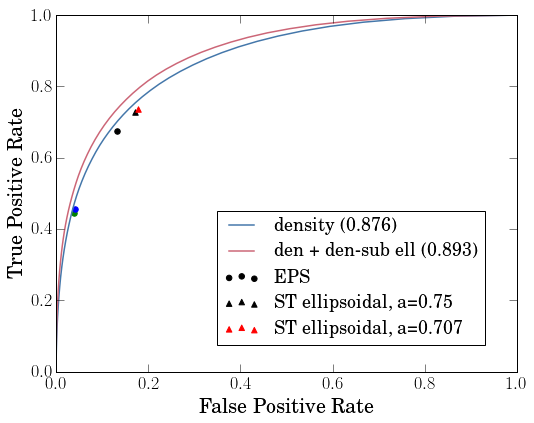

In [169]:
plot.roc_plot(np.column_stack((fpr_den,fpr_den_sub_ell)), np.column_stack((tpr_den,tpr_den_sub_ell )),
              [auc_den,auc_den_sub_ell], labels=["density", "den + den-sub ell"],
              add_EPS=True, fpr_EPS=fpr_EPS, tpr_EPS=tpr_EPS, 
              add_ellipsoidal=True, fpr_ellipsoidal=[fpr_075, 
                                                     fpr_0707
                                                    ], 
              tpr_ellipsoidal=[tpr_075, 
                               tpr_0707
                              ])

# plt.savefig("/Users/lls/Desktop/FPs_shear/rocs_EPS_ellipsoidal.pdf")
plt.scatter(0.038257263033183553, 0.44578718321068378, color="g", s=30)
plt.scatter(0.040643903245830691, 0.4553573756112671, color="b", s=30)

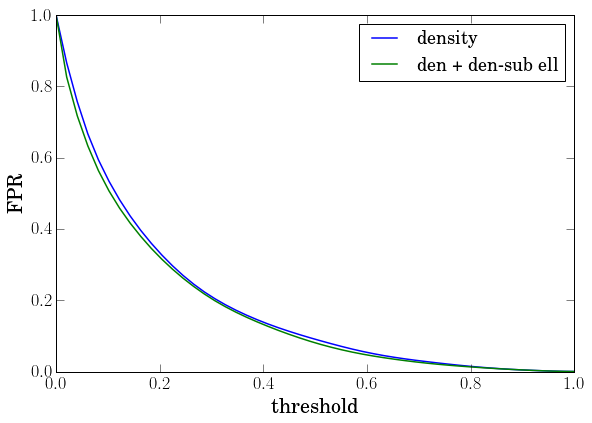

In [59]:
plt.figure(figsize=(9,6))
plt.plot(th, fpr_den, lw=1.5, label="density")
plt.plot(th, fpr_den_sub_ell, lw=1.5, label="den + den-sub ell")
plt.xlabel("threshold")
plt.ylabel("FPR")
plt.legend(loc="best", fontsize=18)

In [13]:
ic = parameters.InitialConditionsParameters(path="/Users/lls/Documents/CODE/")
halos = np.load("/Users/lls/Documents/CODE/stored_files/halo_mass_particles.npy")

In [14]:
print("Total fraction of out particles in halos is " + "%.3f" % (len(np.where(halos[ic.ids_OUT]>0)[0])/len(ic.ids_OUT)))
print("Total fraction of out particles outside halos is " + "%.3f" % (len(np.where(halos[ic.ids_OUT]==0)[0])/len(ic.ids_OUT)))
initial_fraction = len(np.where(halos[ic.ids_OUT]>0)[0])/len(np.where(halos[ic.ids_OUT]==0)[0])
print("The ratio between in halo and out halo for OUT particles is " + "%.3f" % (initial_fraction))

Total fraction of out particles in halos is 0.252
Total fraction of out particles outside halos is 0.748
The ratio between in halo and out halo for OUT particles is 0.337


## Fraction of FPs as a function of mass

In [16]:
th = np.linspace(0, 1, 50)[::-1]

In [34]:
# Find FPs and FNs of density run and of density+density-subtracted ellipticity run

ids_tested, halos_testing_particles = get_ids_and_halos_test_set()

FPs_den_thr = false_positives_ids_index_per_threshold(y_pred_den, y_true_den, th)
FPs_den_den_sub_ell_thr= false_positives_ids_index_per_threshold(y_pred_den_sub_ell, y_true_den_sub_ell, th)

FNs_den_thr = false_negatives_ids_index_per_threshold(y_pred_den, y_true_den, th)
FNs_den_den_sub_ell_thr= false_negatives_ids_index_per_threshold(y_pred_den_sub_ell, y_true_den_sub_ell, th)

In [18]:
n_try, b_try, p = plt.hist(np.log10(halos_testing_particles[y_true_den==1]), bins=np.log10(bins))
plt.yscale("log")

/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


NameError: name 'bins' is not defined

In [ ]:
plt.hist(np.log10(np.unique(halos_testing_particles[y_true_den==1])), bins=np.log10(bins_in))


In [ ]:
print(len(halos_FPs_den_thr)/len(halos_testing_particles[y_true_den==-1]))
print(len(halos_FNs_den_thr)/len(halos_testing_particles[y_true_den==1]))
print(len(halos_FPs_den_thr))
print(len(halos_FNs_den_thr))

In [19]:
# SELECT THE SCALE OF THE PROBABILITY THRESHOLD YOU ARE INTERESTED IN

scale = 28
print("Threshold" + str(th[scale]))
number_of_bins_IN = 25

halos_FPs_den_thr = halos_testing_particles[FPs_den_thr[scale]]
halos_FPs_den_den_sub_ell_thr = halos_testing_particles[FPs_den_den_sub_ell_thr[scale]]

halos_FNs_den_thr = halos_testing_particles[FNs_den_thr[49 - scale]]
halos_FNs_den_den_sub_ell_thr = halos_testing_particles[FNs_den_den_sub_ell_thr[49 - scale]]

h_400_mass = 1836194204280.7886

Threshold0.428571428571


In [20]:
n_FPs_out_out_density = len(halos_FPs_den_den_sub_ell_thr[halos_FPs_den_den_sub_ell_thr == 0])
n_FPs_out_out_den_plus_den_sub_ell = len(halos_FPs_den_thr[halos_FPs_den_thr > 0])
n_total_out_out = len(halos_testing_particles[y_true_den==-1][halos_testing_particles[y_true_den==-1]==0] )

/Users/lls/Documents/mlhalos_code/utils/plot.py:55: RuntimeWarning: divide by zero encountered in log10
  log_numbers = np.log10(numbers)
/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


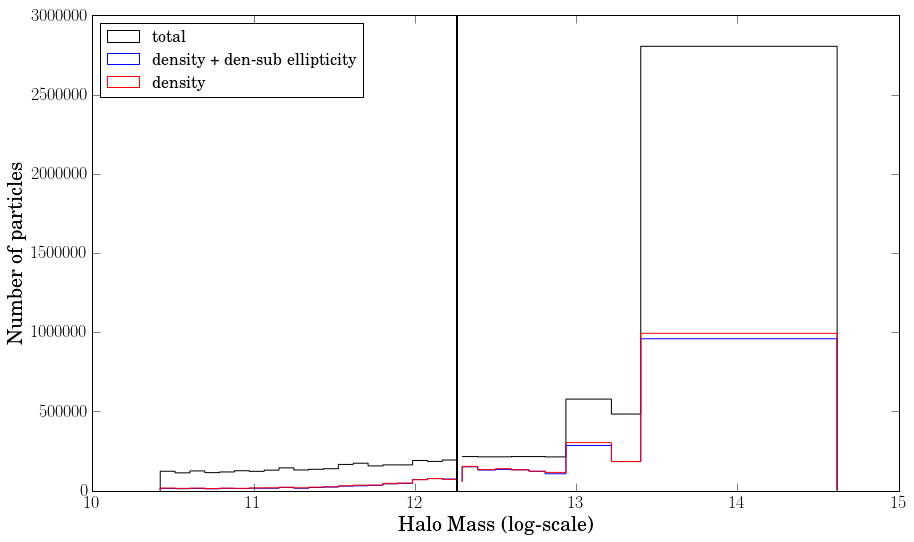

In [21]:
# Plot which halos do the FPs live in in the density run and the density + density-subtracted ellipticity run

plt.figure(figsize=(14,8))

bins_in = plot_utils.get_log_spaced_bins_flat_distribution(halos_testing_particles[y_true_den==1], number_of_bins_init=number_of_bins_IN)

n_total_out, bins_total_out, p = plt.hist(np.log10(halos_testing_particles[y_true_den==-1][halos_testing_particles[y_true_den==-1]>0]), 
                                          bins=20, histtype="step", color="k", label="total")
n_total_in, bins_total_in, p = plt.hist(np.log10(halos_testing_particles[y_true_den==1]), bins=np.log10(bins_in), histtype="step", color="k")


FPs_n_den_sub_ell, bins, patch = plt.hist(np.log10(halos_FPs_den_den_sub_ell_thr[halos_FPs_den_den_sub_ell_thr > 0]), bins=bins_total_out, 
                          histtype="step", label="density + den-sub ellipticity", color="b")
FPs_n_den, bins1, patch1 = plt.hist(np.log10(halos_FPs_den_thr[halos_FPs_den_thr > 0]), bins=bins_total_out, 
                             histtype="step", label="density", color="r")


FNs_n_den_sub_ell, bins, patch = plt.hist(np.log10(halos_FNs_den_den_sub_ell_thr[halos_FNs_den_den_sub_ell_thr > 0]), bins=bins_total_in, 
                          histtype="step", color="b")
FNs_n_den, bins1, patch1 = plt.hist(np.log10(halos_FNs_den_thr[halos_FNs_den_thr > 0]), bins=bins_total_in, 
                             histtype="step", color="r")


plt.axvline(x=np.log10(h_400_mass), color="k", lw=2)

plt.xlabel("Halo Mass (log-scale)")
plt.ylabel("Number of particles")
plt.legend(loc=2, fontsize=16)
# plt.savefig("/Users/lls/Desktop/FPs_shear/num_FPs_per_mass.pdf")

In [547]:
print("Threshold = " + str( 1 - th[scale]))

print("In the density run, the fraction of FPs in halos is " 
      + "%.3f" % (len(halos_FPs_den_thr[halos_FPs_den_thr>0])/len(halos_FPs_den_thr)))
print("In the density run, the fraction of FPs outiside halos is "
      + "%.3f" % (len(halos_FPs_den_thr[halos_FPs_den_thr==0])/len(halos_FPs_den_thr)))
print("In the density+ellipticity run, the fraction of FPs in halos is "
      + "%.3f" % (len(halos_FPs_den_den_sub_ell_thr[halos_FPs_den_den_sub_ell_thr>0])/len(halos_FPs_den_den_sub_ell_thr)))
print("In the density+ellipticity run, the fraction of FPs ouside halos is "
      + "%.3f" % (len(halos_FPs_den_den_sub_ell_thr[halos_FPs_den_den_sub_ell_thr==0])/len(halos_FPs_den_den_sub_ell_thr)))

Threshold = 0.571428571429
In the density run, the fraction of FPs in halos is 0.434
In the density run, the fraction of FPs outiside halos is 0.566
In the density+ellipticity run, the fraction of FPs in halos is 0.435
In the density+ellipticity run, the fraction of FPs ouside halos is 0.565


In [22]:
# Normalise the two histograms by total number of OUT particles in each mass bin

FPs_r_den_sub_ell = FPs_n_den_sub_ell/n_total_out
FPs_r_den = FPs_n_den/n_total_out

FNs_r_den_sub_ell = FNs_n_den_sub_ell[n_total_in>0]/n_total_in[n_total_in>0]
FNs_r_den = FNs_n_den[n_total_in>0]/n_total_in[n_total_in>0]

r_density_FPs_out_out = n_FPs_out_out_density/n_total_out_out
r_den_den_sub_ell_FPs_out_out = n_FPs_out_out_den_plus_den_sub_ell/n_total_out_out


# num_halos_bins_in, bla = np.histogram(np.log10(np.unique(halos_testing_particles[y_true_den==1])), bins=bins_total_in)
# num_halos_bins_out, bla = np.histogram(
#     np.log10(np.unique(halos_testing_particles[y_true_den==-1][halos_testing_particles[y_true_den==-1]>0])), 
#     bins=bins_total_out)

# FNs_yerr = 1/np.sqrt(num_halos_bins_in)
# FPs_yerr = 1/np.sqrt(num_halos_bins_out)

FNs_yerr = 1/np.sqrt(n_total_in[n_total_in>0])
FPs_yerr = 1/np.sqrt(n_total_out)

In [549]:
num_halos_bins_out

array([  8,   9,  12,  14,  18,  22,  27,  33,  41,  51,  63,  77,  92,
       111, 122, 121, 114, 116, 103,  85])

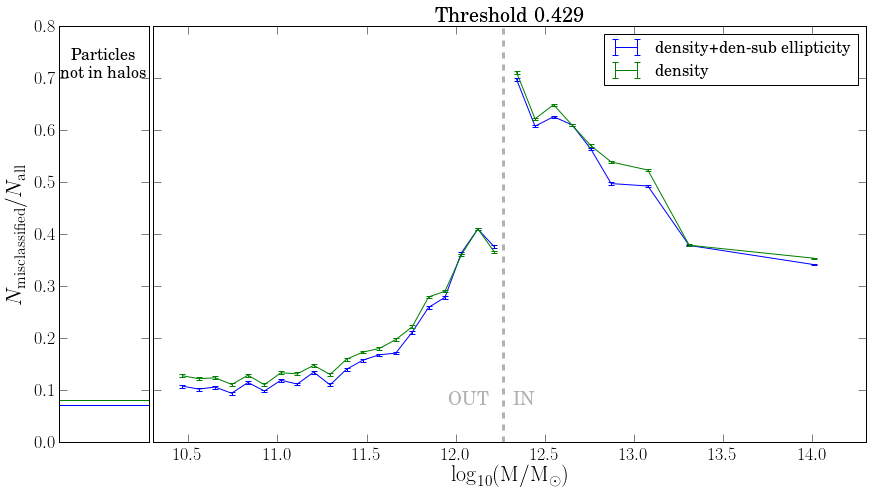

In [23]:
f, (ax2, ax1) = plt.subplots(1, 2, sharey=True, gridspec_kw = {'width_ratios':[1, 8]}, figsize=(14,7))

c = distinct_colours.get_distinct(2)

b_mid_out = (bins_total_out[:-1] + bins_total_out[1:])/2
b_mid_in = ((bins_total_in[:-1] + bins_total_in[1:])/2)[n_total_in>0]

ax1.errorbar(b_mid_out, FPs_r_den_sub_ell, yerr=FPs_yerr, color="b", label="density+den-sub ellipticity")
ax1.errorbar(b_mid_out, FPs_r_den, yerr=FPs_yerr, color="g", label="density")

ax1.errorbar(b_mid_in, FNs_r_den_sub_ell, yerr=FNs_yerr, color="b")
ax1.errorbar(b_mid_in, FNs_r_den, yerr=FNs_yerr, color="g")

ax2.axhline(r_density_FPs_out_out, color="g")
ax2.axhline(r_den_den_sub_ell_FPs_out_out, color="b")
ax2.set_xticks([])

ax1.legend(loc="best", fontsize=16)
f.subplots_adjust(wspace=0.01)
ax1.set_xlabel(r"$\log_{10}(\mathrm{M}/\mathrm{M}_{\odot})$", fontsize=22)
ax2.set_ylabel(r"$N_{\mathrm{misclassified}}/ N_{\mathrm{all}}$", fontsize=22)
ax1.set_xlim(10.3, 14.3)

ax1.axvline(x=np.log10(h_400_mass), color="grey", alpha=100, ls = "--", lw=3)
f.text(0.60, 0.2, "IN", fontweight="bold",fontsize=18, color="grey", alpha=100)
f.text(0.535, 0.2, "OUT", fontweight="bold",fontsize=18, color="grey", alpha=100)

f.text(0.151, 0.85, "Particles \n not in halos", multialignment='center', fontweight="bold",fontsize=16, color="k")
plt.title("Threshold " + "%.3f" % th[scale])

# plt.savefig("/Users/lls/Desktop/compare.pdf")

/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


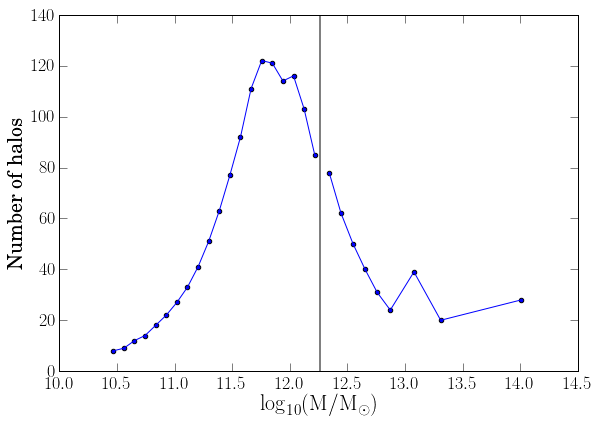

In [24]:
n, b = np.histogram(np.log10(np.unique(halos_testing_particles[y_true_den==1])), bins=np.log10(bins_in))
n1, b1 = np.histogram(np.log10(np.unique(halos_testing_particles[y_true_den==-1][halos_testing_particles[y_true_den==-1]>0])), bins=bins_total_out)

plt.figure(figsize=(9,6))
plt.scatter(np.concatenate((b_mid_out, b_mid_in)), np.concatenate((n1, n)))
plt.plot(np.concatenate((b_mid_out, b_mid_in)), np.concatenate((n1, n)))
plt.axvline(x=np.log10(h_400_mass), color="grey", lw=2)
plt.xlabel(r"$\log_{10}(\mathrm{M}/\mathrm{M}_{\odot})$", fontsize=22)
plt.ylabel("Number of halos")
# plt.savefig("/Users/lls/Desktop/FPs_shear/num_halo_mass_bins.pdf")

In [534]:
n

array([76, 66, 52, 42, 33, 26, 20, 36, 20, 21])

/Users/lls/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


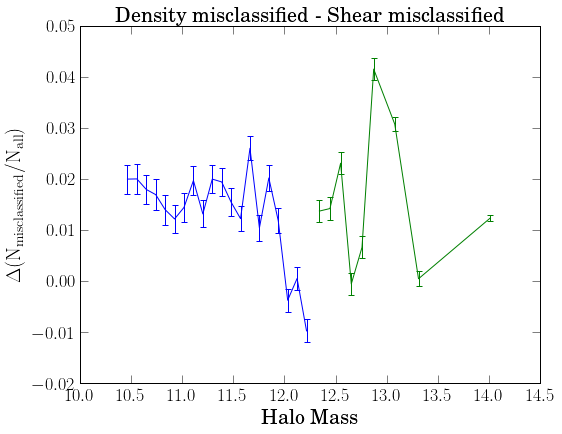

In [25]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(b_mid_out, FPs_r_den - FPs_r_den_sub_ell, yerr=FPs_yerr)
plt.errorbar(b_mid_in, FNs_r_den - FNs_r_den_sub_ell, yerr=FNs_yerr)
plt.title("Density misclassified - Shear misclassified")
plt.legend(loc="best", fontsize=16)
plt.xlabel("Halo Mass")
plt.ylabel(r"$\Delta (\mathrm{N}_{\mathrm{misclassified}}/\mathrm{N}_{\mathrm{all}})$")
# plt.savefig("/Users/lls/Desktop/FPs_shear/difference_ratio_FPs_per_mass.pdf")

## Fraction of FPs in halos / FPs out halos in two runs

In [73]:
def get_ratio_false_positives_in_out_halos_per_threshold(y_predicted, y_true, threshold, halos_particles):
    shape = len(threshold)

    r_in = np.zeros(shape, )
    r_out = np.zeros(shape, )

    for i in range(shape):
        # print(threshold[i])
        FPs = get_false_positives_index(y_predicted, y_true, threshold=threshold[i])

        in_h = np.where(halos_particles[FPs] > 0)[0]
        out_h = np.where(halos_particles[FPs] == 0)[0]
        tot = halos_particles[FPs]

        if len(out_h)!=0:
            r_in[i] = len(in_h) / len(tot) 
            r_out[i] = len(out_h) / len(tot)
        else:
            r_in[i] = 0
            r_out[i] = 0
            #print("FPs in halos are " + str(len(in_h)) + " for threshold " + str(threshold[i]))
            #print("FPs out halos are " + str(len(out_h)) + " for threshold " + str(threshold[i]))

    return r_in, r_out

In [7]:
ic = parameters.InitialConditionsParameters(path="/Users/lls/Documents/CODE/")
halos = np.load("/Users/lls/Documents/CODE/stored_files/halo_mass_particles.npy")

r_initial_in = len(np.where(halos[ic.ids_OUT]>0)[0])/len(ic.ids_OUT)
r_initial_out = len(np.where(halos[ic.ids_OUT]==0)[0])/len(ic.ids_OUT)

print("Total fraction of out particles in halos is " + "%.3f" % (len(np.where(halos[ic.ids_OUT]>0)[0])/len(ic.ids_OUT)))
print("Total fraction of out particles outside halos is " + "%.3f" % (len(np.where(halos[ic.ids_OUT]==0)[0])/len(ic.ids_OUT)))
initial_fraction = len(np.where(halos[ic.ids_OUT]>0)[0])/len(np.where(halos[ic.ids_OUT]==0)[0])
print("The ratio between in halo and out halo for OUT particles is " + "%.3f" % (initial_fraction))

Total fraction of out particles in halos is 0.252
Total fraction of out particles outside halos is 0.748
The ratio between in halo and out halo for OUT particles is 0.337


In [74]:
FPs = get_false_positives_index(y_pred_den, y_true_den, threshold=threshold[0])

In [95]:
y_pred_ell_prol = np.load(path + "predicted_den_sub_ell_prol.npy")
y_true_ell_prol  = np.load(path + "true_den_sub_ell_prol.npy")

In [76]:
threshold = np.linspace(0,1,50)[::-1]

r_in_den, r_out_den = get_ratio_false_positives_in_out_halos_per_threshold(y_pred_den, y_true_den, threshold, 
                                                                           halos_testing_particles)
r_in_den_sub_ell, r_out_den_sub_ell = get_ratio_false_positives_in_out_halos_per_threshold(y_pred_den_sub_ell, 
                                                                                           y_true_den_sub_ell, threshold, 
                                                                                           halos_testing_particles)
# r_in_ell_prol, r_out_ell_prol = get_ratio_false_positives_in_out_halos_per_threshold(y_pred_ell_prol, y_true_ell_prol, threshold, 
#                                                                                            halos_testing_particles)

In [85]:
ic.halo[400]['mass'].sum()
(halos_testing_particles < ic.halo[400]['mass'].sum()) & (halos_testing_particles > 0)

SimArray([False, False, False, ..., False, False, False], dtype=bool)

## Misclassified OUT particles density vs density + ellipticity

In [112]:
print(" DENSITY RUN ")
print(" ")

print("The false positive rate of the density run at threshold " + "%.3f" % threshold[28] + " is " + "%.3f" % fpr_den[28])


total_out_no_halo = len(np.where(halos_testing_particles == 0)[0])
total_out_some_halo = len(np.where((halos_testing_particles < ic.halo[400]['mass'].sum()) & (halos_testing_particles > 0))[0])

FPs_in_no_halo_den = len(np.where(halos_testing_particles[FPs_den_thr[28]]==0)[0])
FPs_in_some_halo_den = len(np.where(halos_testing_particles[FPs_den_thr[28]]>0)[0])
print(" ")

print("Number of misclassified particles in no halo / total particles in no halo = " 
      + "%.3f" % (FPs_in_no_halo_den/total_out_no_halo) + " at threshold " + "%.3f" % threshold[28])
print("Number of misclassified particles of some 'OUT class' halo / total particles in OUT halos = " 
      + "%.3f" % (FPs_in_some_halo_den/total_out_some_halo)+ " at threshold " + "%.3f" % threshold[28])


print(" ")
print(" DENSITY + ELLIPTICITY RUN ")
print(" ")

print("The false positive rate of the density+ellipticity run at threshold " + "%.3f" % threshold[28] + " is " + "%.3f" % fpr_den_sub_ell[28])

print(" ")



FPs_in_no_halo_den_ell = len(np.where(halos_testing_particles[FPs_den_den_sub_ell_thr[28]]==0)[0])
FPs_in_some_halo_den_ell = len(np.where(halos_testing_particles[FPs_den_den_sub_ell_thr[28]]>0)[0])

print("Number of misclassified particles in no halo / total particles in no halo = " 
      + "%.3f" % (FPs_in_no_halo_den_ell/total_out_no_halo) + " at threshold " + "%.3f" % threshold[28])
print("Number of misclassified particles of some 'OUT class' halo / total particles in OUT halos = " 
      + "%.3f" % (FPs_in_some_halo_den_ell/total_out_some_halo)+ " at threshold " + "%.3f" % threshold[28])

 DENSITY RUN 
 
The false positive rate of the density run at threshold 0.429 is 0.123
 
Number of misclassified particles in no halo / total particles in no halo = 0.093 at threshold 0.429
Number of misclassified particles of some 'OUT class' halo / total particles in OUT halos = 0.212 at threshold 0.429
 
 DENSITY + ELLIPTICITY RUN 
 
The false positive rate of the density+ellipticity run at threshold 0.429 is 0.115
 
Number of misclassified particles in no halo / total particles in no halo = 0.087 at threshold 0.429
Number of misclassified particles of some 'OUT class' halo / total particles in OUT halos = 0.199 at threshold 0.429


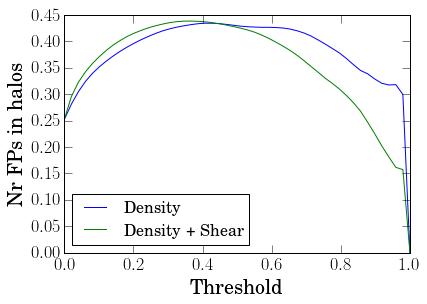

In [77]:
plt.plot(threshold, r_in_den, color="b", label="Density")
plt.plot(threshold, r_in_den_sub_ell, color="g", label="Density + Shear")
# plt.axhline(y=r_initial_in, color="b", ls="--")
# plt.axhline(y=r_initial_out, color="g", ls="--")
plt.legend(loc="best", fontsize=16)
plt.xlabel("Threshold")
plt.ylabel("Nr FPs in halos")

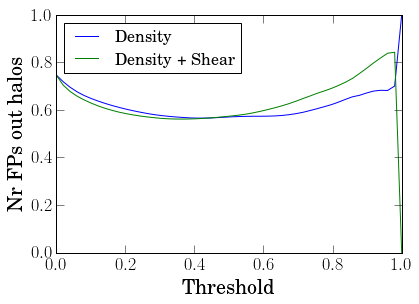

In [78]:
plt.plot(threshold, r_out_den, color="b", label="Density")
plt.plot(threshold, r_out_den_sub_ell, color="g", label="Density + Shear")
# plt.axhline(y=r_initial_in, color="b", ls="--")
# plt.axhline(y=r_initial_out, color="g", ls="--")
plt.legend(loc="best", fontsize=16)
plt.xlabel("Threshold")
plt.ylabel("Nr FPs out halos")

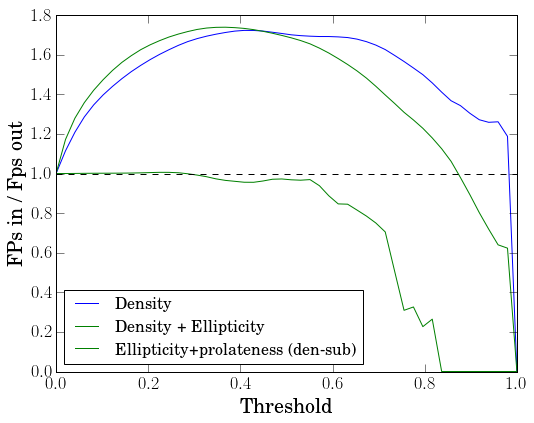

In [109]:
plt.figure(figsize=(8,6))

plt.plot(threshold, r_in_den/r_initial_in, color="b", label="Density")
#plt.plot(threshold, r_out/r_initial_out, color="g", label="Out halos")

plt.plot(threshold, r_in_den_sub_ell/r_initial_in, color="g", label="Density + Ellipticity")
#plt.plot(threshold, r_out_den_sub_ell/r_initial_out, color="g", label="Out halos", lw=2)

plt.plot(threshold, r_in_ell_prol/r_initial_in, color="g", label="Ellipticity+prolateness (den-sub)")

plt.axhline(y=1, color="k", ls="--")

plt.legend(loc="best", fontsize=16)
plt.xlabel("Threshold")
plt.ylabel("FPs in / Fps out")
plt.savefig("/Users/lls/Desktop/FPs_shear/FPs_in_vs_out_threshold.pdf")

In [456]:
print("Threshold " + str(1 - threshold[scale]) + " :")
print("False positives in halos are " 
      + "%.3f" % (len(halos_FPs_den_thr[halos_FPs_den_thr>0])/len(halos_FPs_den_thr[halos_FPs_den_thr==0])/initial_fraction)
      + " times the false positive in no halos in the density-only run.")
print("False positives in halos are " 
      + "%.3f" % (len(halos_FPs_den_den_sub_ell_thr[halos_FPs_den_den_sub_ell_thr>0])/
                  len(halos_FPs_den_den_sub_ell_thr[halos_FPs_den_den_sub_ell_thr==0])/initial_fraction)
      + " times the false positive in no halos in the density + density-subtracted ellipticity run.")

Threshold 0.591836734694 :
False positives in halos are 2.278 times the false positive in no halos in the density-only run.
False positives in halos are 2.301 times the false positive in no halos in the density + density-subtracted ellipticity run.


In [662]:
r_in_vs_out_den = get_ratio_false_positives_in_out_halos_per_threshold(y_pred_den, y_true_den, threshold, halos_testing_particles, initial_fraction)
r_in_vs_out_den_ell = get_ratio_false_positives_in_out_halos_per_threshold( y_pred_den_sub_ell, y_true_den, threshold, halos_testing_particles, initial_fraction)

Here I am plotting the ratio of FPs in halos / FPs not in halos


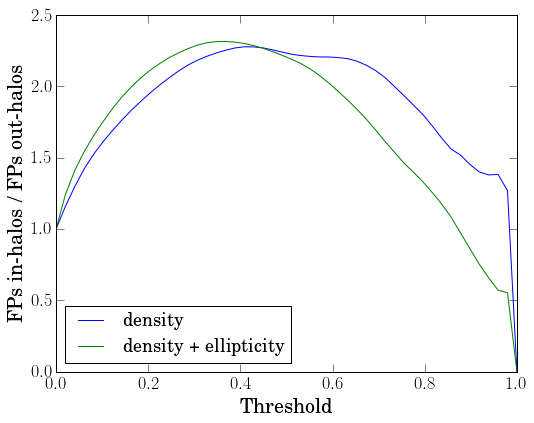

In [663]:
plt.figure(figsize=(8,6))
plt.plot(threshold, r_in_vs_out_den, label="density")
plt.axhline(y=0, c="k", ls="--")
plt.plot(threshold, r_in_vs_out_den_ell, label="density + ellipticity")
plt.legend(loc="best", fontsize=18)
plt.xlabel("Threshold")
plt.ylabel("FPs in-halos / FPs out-halos")

print("Here I am plotting the ratio of FPs in halos / FPs not in halos")
plt.savefig("/Users/lls/Desktop/FPs_shear/ratio_FPs_in_out_halos.pdf")

Here I am plotting the difference in ratio of FPs in halos / FPs not in halos


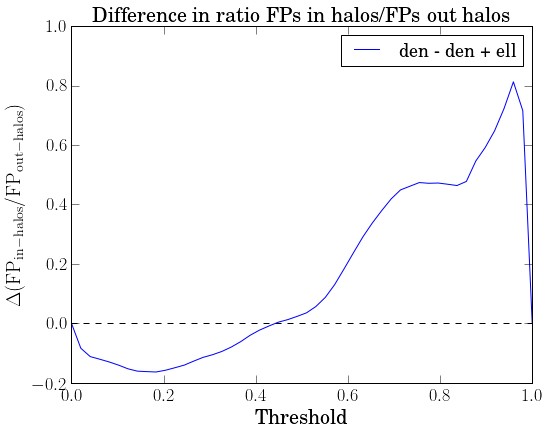

In [664]:
plt.figure(figsize=(8,6))
plt.axhline(y=0, c="k", ls="--")
plt.plot(threshold, r_in_vs_out_den - r_in_vs_out_den_ell, label="den - den + ell")
plt.legend(loc="best", fontsize=18)
plt.xlabel("Threshold")
plt.ylabel(r"$\Delta (\mathrm{FP_{in-halos} / FP_{out-halos}})$")
plt.title("Difference in ratio FPs in halos/FPs out halos")

print("Here I am plotting the difference in ratio of FPs in halos / FPs not in halos")
plt.savefig("/Users/lls/Desktop/FPs_shear/difference_ratio_FPs_in_out_halos.pdf")

In [162]:
# Plot difference in fraction of FPs in halos as a function of threshold for density-only and density+den-sub
# ellipticity case

# threshold = np.linspace(0., 1., 50)[::-1]
# FPs_den_in_halos, FPs_den_out_halos = get_percentage_false_positives_in_out_halos_per_threshold(y_pred_den,
#                                                                                                 y_true_den,
#                                                                                                 threshold,
#                                                                                                 halos_testing_particles)
# FPs_den_sub_ell_in_halos, FPs_den_sub_ell_out_halos = get_percentage_false_positives_in_out_halos_per_threshold(
#     y_pred_den_sub_ell, y_true_den, threshold, halos_testing_particles)

In [160]:
# plot_difference_fraction_FPs(FPs_den_in_halos, FPs_den_sub_ell_in_halos, label="belong to halos", figsize=(9,6))

In [161]:
# plot_difference_fraction_FPs(FPs_den_out_halos, FPs_den_sub_ell_out_halos, label="not belong to halos", figsize=(9,6))

# Which FPs went from wrong to right classification?

In [39]:
threshold = np.linspace(0,1,50)[::-1]

In [40]:
# Which FPs went from wrong to right classification?

FPs_den_ind = false_positives_ids_index_per_threshold(y_pred_den, y_true_den, threshold)
FPs_den_den_sub_ell_ind = false_positives_ids_index_per_threshold(y_pred_den_sub_ell, y_true_den, threshold)

assert FPs_den_ind.shape[0] == len(threshold)
assert FPs_den_den_sub_ell_ind.shape[0] == len(threshold)

common_FPs = np.array([ids_tested[FPs_den_ind[i] & FPs_den_den_sub_ell_ind[i]] for i in range(len(threshold))])
wrong_to_correct_density_FPs = np.array([ids_tested[FPs_den_ind[i] & ~FPs_den_den_sub_ell_ind[i]]
                                         for i in range(len(threshold))])

halos_common_FPs = np.array([halos_testing_particles[FPs_den_ind[i] & FPs_den_den_sub_ell_ind[i]]
                             for i in range(len(threshold))])
halos_wrong_to_correct_density_FPs = np.array([halos_testing_particles[FPs_den_ind[i] & ~FPs_den_den_sub_ell_ind[i]]
                                         for i in range(len(threshold))])

In [46]:
# Whicht TNs became FPs?

TNs_den_ind = true_negatives_ids_index_per_threshold(y_pred_den, y_true_den, threshold)
# FPs_den_den_sub_ell_ind = false_positives_ids_index_per_threshold(y_pred_den_sub_ell, y_true_den, threshold)

assert FPs_den_ind.shape[0] == len(threshold)
assert FPs_den_den_sub_ell_ind.shape[0] == len(threshold)


correct_to_wrong_density_TNs = np.array([ids_tested[TNs_den_ind[i] & FPs_den_den_sub_ell_ind[i]]
                                         for i in range(len(threshold))])

halos_correct_to_wrong_density_TNs = np.array([halos_testing_particles[TNs_den_ind[i] & FPs_den_den_sub_ell_ind[i]]
                                         for i in range(len(threshold))])


## FPs which switched to correctly classified / FPs in density-run for each mass bin

In [48]:
num_FPs_den_per_threshold = np.zeros((50,))
num_FPs_switching = np.zeros((50,))

num_TNs_den_per_threshold = np.zeros((50,))
num_TNs_switching = np.zeros((50,))

# num_FPs_same= np.zeros((50,))
for i in range(50):
    num_FPs_switching[i] = len(halos_wrong_to_correct_density_FPs[i])
    num_FPs_den_per_threshold[i] = len(ids_tested[FPs_den_thr[i]])
    
    num_TNs_switching[i] = len(halos_correct_to_wrong_density_TNs[i])
    num_TNs_den_per_threshold[i] = len(ids_tested[TNs_den_ind[i]])
    # num_FPs_same[i] = len(halos_common_FPs[i])

In [69]:
num_FPs_den_per_threshold[1:-1] + num_TNs_den_per_threshold[1:-1])

array([ 11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.,  11525668.,  11525668.,
        11525668.,  11525668.,  11525668.])

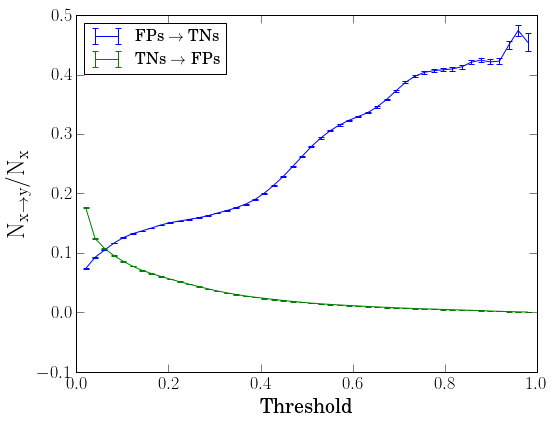

In [72]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(threshold[1:-1], num_FPs_switching[1:-1]/num_FPs_den_per_threshold[1:-1], 
             yerr=1/np.sqrt(num_FPs_den_per_threshold[1:-1]), label=r"FPs $\rightarrow$ TNs")
# plt.errorbar(threshold, num_FPs_same/num_FPs_den_per_threshold, 
#              yerr=1/np.sqrt(num_FPs_den_per_threshold), label="common")
plt.errorbar(threshold[1:-1], num_TNs_switching[1:-1]/num_TNs_den_per_threshold[1:-1], 
             yerr=1/np.sqrt(num_TNs_den_per_threshold[1:-1]), label=r"TNs $\rightarrow$ FPs")
plt.xlabel("Threshold")
plt.ylabel(r"$\mathrm{N_{x \rightarrow y} /N_{x}}$", fontsize=24)
plt.legend(loc="best", fontsize=16)
plt.savefig("/Users/lls/Desktop/FPs_shear/switching_particles.pdf")

In [59]:
num_TNs_den_per_threshold

array([ 11525658.,  11521470.,  11512905.,  11501328.,  11488347.,
        11473358.,  11455675.,  11434918.,  11411176.,  11383825.,
        11353386.,  11320055.,  11283900.,  11245602.,  11205288.,
        11163350.,  11117878.,  11067742.,  11012460.,  10949459.,
        10878917.,  10800859.,  10715948.,  10625646.,  10531467.,
        10433712.,  10331490.,  10223063.,  10108258.,   9984396.,
         9849395.,   9703340.,   9543058.,   9366196.,   9168884.,
         8948873.,   8699103.,   8418435.,   8105284.,   7759698.,
         7379480.,   6960924.,   6495026.,   5970720.,   5372376.,
         4678998.,   3840702.,   2795949.,   1542057.,         0.])

In [671]:
import sys
sys.path.append("/Users/lls/Documents/mlhalos_code")
from utils import plot

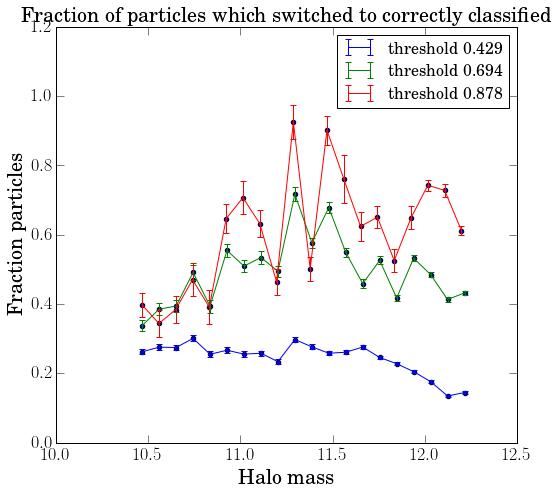

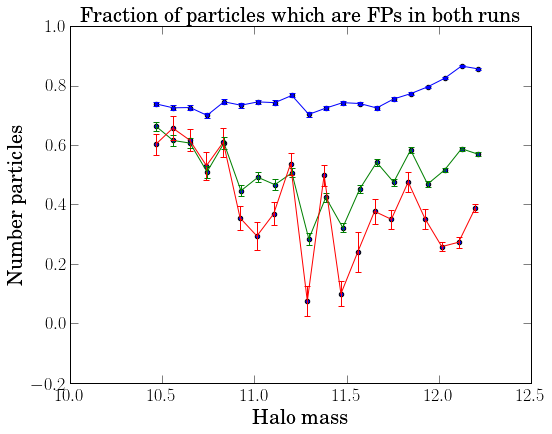

In [677]:
plt.figure(figsize=(8, 7))
for scale in [28, 15, 6]:
    halos_FPs_den_thr = halos_testing_particles[FPs_den_thr[scale]]
    den_FPs_in_halos = np.log10(halos_FPs_den_thr[halos_FPs_den_thr>0])
    bins = 20
    n_density_FPs ,bins_den_FPs = np.histogram(den_FPs_in_halos , bins=bins)

    wrong_to_right_halos = np.log10(halos_wrong_to_correct_density_FPs[scale][halos_wrong_to_correct_density_FPs[scale]>0])
    n_wrong_to_right, b = np.histogram(wrong_to_right_halos, bins=bins_den_FPs)
    
    plt.scatter((bins_den_FPs[:-1] + bins_den_FPs[1:])/2, n_wrong_to_right/n_density_FPs )
    plt.errorbar((bins_den_FPs[:-1] + bins_den_FPs[1:])/2, n_wrong_to_right/n_density_FPs, yerr=1/np.sqrt(n_density_FPs),
                label = "threshold " + "%.3f" % (threshold[scale]))
plt.xlabel("Halo mass")
plt.ylabel("Fraction particles")
plt.legend(loc="best", fontsize=16)
plt.title("Fraction of particles which switched to correctly classified")
plt.savefig("/Users/lls/Desktop/FPs_shear/fraction_switching_FPs.pdf")

plt.figure(figsize=(8,6))
for scale in [28, 15, 6]:
    halos_FPs_den_thr = halos_testing_particles[FPs_den_thr[scale]]
    den_FPs_in_halos = np.log10(halos_FPs_den_thr[halos_FPs_den_thr>0])
    n_density_FPs ,bins_den_FPs = np.histogram(den_FPs_in_halos , bins=bins)
    
    common_halos = np.log10(halos_common_FPs[scale][halos_common_FPs[scale]>0])
    n_common, b = np.histogram(common_halos, bins=bins_den_FPs)
    plt.scatter((bins_den_FPs[:-1] + bins_den_FPs[1:])/2, n_common/n_density_FPs)
    plt.errorbar((bins_den_FPs[:-1] + bins_den_FPs[1:])/2, n_common/n_density_FPs, yerr=1/np.sqrt(n_density_FPs))
plt.xlabel("Halo mass")
plt.ylabel("Number particles")
plt.title("Fraction of particles which are FPs in both runs")

In [653]:
frac_w_to_cor = np.zeros((50, 2))

for i in range(len(threshold)):
    in_h = len(np.where(halos_wrong_to_correct_density_FPs[i] > 0)[0])
    out_h = len(np.where(halos_wrong_to_correct_density_FPs[i] == 0)[0])
    if in_h != 0:
        in_halos = in_h/ len(halos_wrong_to_correct_density_FPs[i])
    else:
        in_halos = in_h
    if out_h != 0:
        out_halos = out_h / len(halos_wrong_to_correct_density_FPs[i])
    else:
        out_halos = out_h

    frac_w_to_cor[i,0] = in_halos
    frac_w_to_cor[i, 1] = out_halos

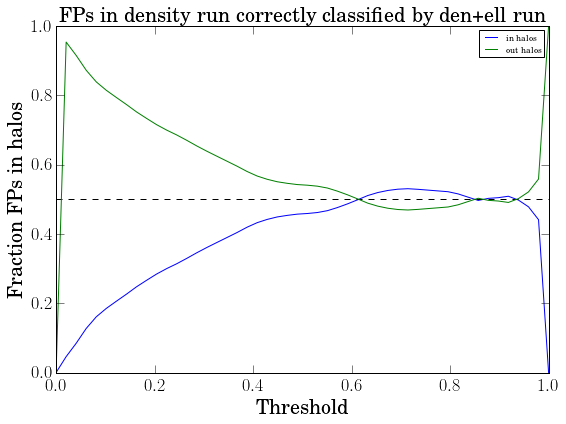

In [654]:
plt.figure(figsize=(8,6))
plt.plot(threshold, frac_w_to_cor[:,0], label="in halos")
plt.axhline(y=0.5, color="k", ls="--")
plt.plot(threshold, frac_w_to_cor[:,1], label="out halos")
plt.xlabel("Threshold")
plt.ylabel("Fraction FPs in halos")
plt.legend(loc="best")
plt.title("FPs in density run correctly classified by den+ell run")
plt.tight_layout()

# Where do false positives in no halos belong?

## Consider threshold[28]

In [35]:
Fps_ids_den = ids_tested[(FPs_den_thr[28]) & (halos_testing_particles==0)]
Fps_ids_den_den_sub_ell = ids_tested[(FPs_den_den_sub_ell_thr[28]) & (halos_testing_particles==0)]

In [36]:
np.save("/Users/lls/Desktop/Fps_th_28_den.npy", Fps_ids_den)
np.save("/Users/lls/Desktop/Fps_th_28_den_den_sub_ell.npy", Fps_ids_den_den_sub_ell)